In [1]:
import argparse
import matplotlib.pyplot as plt
import scipy
import math

import jax
import jax.numpy as jnp     
import numpy as np
from jax.config import config

import awkward as awk

import flax
from flax import linen as nn          
from flax.training import train_state, checkpoints
from flax.core.frozen_dict import freeze, unfreeze
import optax   

import torch

from functools import partial

import diffvert
import diffvert.models.NDIVE
import diffvert.utils.data_format
from diffvert.models.train_config import TrainConfig
from diffvert.utils.billoir_vertex_fit import billoir_vertex_fit

import uproot

import numpy as np

import diffvert.utils.data_format as daf
import diffvert.evaluation.plot_helpers as ph

from dash import Dash, html, dcc, Input, Output, State, ctx
import plotly.io as io
import plotly.graph_objects as go 

import chart_studio.plotly as py


/gpfs/slac/atlas/fs1/d/jshoe/miniconda3/envs/plotly/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_name = "test_again"
USING_GHOST=False
outs = ph.get_test_output(config_name, 40)
# perf_weight_outs = ph.get_test_output("ftag_true_weights_all_loss", 80)

could not find cached outputs, running inference
2
50
/gpfs/slac/atlas/fs1/d/jshoe/saved_models/test_again/40
cfg: TrainConfig(model_name='ftag', num_epochs=200, samples='/gpfs/slac/atlas/fs1/d/recsmith/Vertexing/samples/all_flavors/all_flavors', batch_size=100, learning_rate=0.001, pretrained_NDIVE=False, track_weight_activation=1, num_attention_layers=3, num_attention_heads=2, jet_flavor_loss=True, track_origin_loss=True, track_pairing_loss=True, vertex_loss=True, use_mse_loss=True, normalize_vertex_loss=False, chi_squared_loss=False, track_weight_loss=False, vertexer=1, use_ghost_track=False, clip_vertex=True, use_one_hot_encoding=False, use_early_stopping=True, use_adam=True, use_cosine_decay_schedule=False, use_learning_rate_decay_when_stalled=True, config_name='test_again')
loaded model parameter count: 62457
final input shape: (60000, 15, 51)
final output shape: (60000, 30)
final input shape: (60000, 15, 51)
final output shape: (60000, 30)
final input shape: (60000, 15, 51)
fina

In [49]:
import importlib
importlib.reload(diffvert.utils.data_format)
importlib.reload(diffvert.evaluation.plot_helpers)
import diffvert.utils.data_format as daf
import diffvert.evaluation.plot_helpers as ph


In [3]:
""" messing around with data, checking things. """
b_ins = outs["b_input_arr"]
jet_idx = 5
print(b_ins[jet_idx,:,daf.JetData.TRACK_PT])
print(b_ins[jet_idx,:,daf.JetData.TRACK_JET_PT])
print(b_ins[jet_idx,:,daf.JetData.TRACK_JET_ETA])

print(np.sum(b_ins[jet_idx,:,daf.JetData.TRACK_PT]))

data = daf.get_track_inputs(b_ins[0:1])
print(data[0])

# mask = daf.create_tracks_mask(b_ins[0:1])
# print(mask)

# mask_tracks = jnp.repeat(
#     mask, daf.NUM_JET_INPUT_PARAMETERS,
# ).reshape(1, 15, daf.NUM_JET_INPUT_PARAMETERS)
# print(mask_tracks)

# track_inputs = daf.get_track_inputs(b_ins[0:1])
# track_inputs = jnp.where(mask_tracks == 0, 0, track_inputs)
# print(track_inputs)

[ 1.26420999  1.03223252  6.6473875  30.99436569  1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]
[74.04673004 74.04673004 74.04673004 74.04673004  1.          1.
  1.          1.          1.          1.          1.          1.
  1.          1.          1.        ]
[1.12009573 1.12009573 1.12009573 1.12009573 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
50.93819570541382
[[ 2.99882603e+00 -4.78535099e-03  1.20530665e-01 -2.12960339e+00
   5.87466419e-01  1.99939575e-04 -3.82979178e+00  3.48316729e-01
   5.22735454e-02  9.02692974e-02  1.50267676e-01  2.09529372e-03
   9.96216899e-04  1.13868982e-05  5.30119464e-02  8.02106380e-01
   4.92801258e+00  1.23127592e+00]
 [ 4.78849053e-01  8.09028596e-02 -1.79949962e-02 -2.61752391e+00
   5.93479514e-01  1.25213584e-03 -5.66438246e+00  1.48822770e-01
   8.27152655e-03  1.09999999e-01  1.80000007e-01  2.60000001e

In [7]:
def graph_track(track, dist_limit=None):
    """ graph track 

    Args:
        track: 'num_track_params' array followind JetData 
    """
    d_0 = track[daf.JetData.TRACK_D0]
    z_0 = track[daf.JetData.TRACK_Z0]
    phi = track[daf.JetData.TRACK_PHI]
    theta = track[daf.JetData.TRACK_THETA]
    rho = track[daf.JetData.TRACK_RHO]

    color = "none" # if ends up none, something is wrong
    if int(track[daf.JetData.TRACK_FROM_B]) == 1:
        color = "mediumseagreen"
    if int(track[daf.JetData.TRACK_FROM_C]) == 1:
        color = "purple"
    if int(track[daf.JetData.TRACK_FROM_ORIGIN]) == 1:
        color = "orange"
    if int(track[daf.JetData.TRACK_FROM_OTHER]) == 1:
        color = "black"

    xs, ys, zs = [], [], []
    # print(f"rho: {rho}, recip: {1/rho}")

    # iterate under assumption that delta << 1/rho according to billoir paper
    if dist_limit is None: dist_limit = 5
    # for delta in np.linspace(-dist_limit, dist_limit, 100):
    for delta in np.linspace(0, dist_limit, 100):
        x = d_0 * np.sin(phi) + delta * np.cos(phi) - delta*delta*rho/2 * np.sin(phi)
        y = -d_0 * np.cos(phi) + delta * np.sin(phi) + delta*delta*rho/2 * np.cos(phi)
        z = z_0 + delta * 1 / np.tan(theta)
        xs.append(x)
        ys.append(y)
        zs.append(z)

    return go.Scatter3d(x=xs, y=ys, z=zs, mode="lines", line=dict(color=color))

def graph_jet(jet_input, jet_output, perf_weight_output):
    """ graph all tracks in a jet
    Args:
        jet: 'num_tracks' x 'num_track' params'
    """
    n_tracks = int(jet_input[0,daf.JetData.N_TRACKS])
    print(f"n_tracks: {n_tracks}")
    plots = []

    hadron_coords = jet_input[0][daf.JetData.HADRON_X:daf.JetData.HADRON_Z+1]
    decay_length = np.linalg.norm(hadron_coords)

    predicted_vertex = jet_output[daf.JetPrediction.VERTEX_X:daf.JetPrediction.VERTEX_Z+1]
    perf_weights_predicted_vertex = perf_weight_output[daf.JetPrediction.VERTEX_X:daf.JetPrediction.VERTEX_Z+1]
    vertex_dist = np.linalg.norm(np.array(hadron_coords)-np.array(predicted_vertex))
    predicted_decay_length = np.linalg.norm(predicted_vertex)
    perf_vtx_dist = np.linalg.norm(np.array(hadron_coords)-np.array(perf_weights_predicted_vertex))

    weights = jet_output[daf.JetPrediction.VERTEX_TRACK_STARTS:]
    normalized_weights = weights/np.max(weights)

    tot_weight = np.sum(normalized_weights)
    weight_on_b = np.sum(normalized_weights[jet_input[USING_GHOST:,daf.JetData.TRACK_FROM_B].astype(int)==1])
    weight_on_c = np.sum(normalized_weights[jet_input[USING_GHOST:,daf.JetData.TRACK_FROM_C].astype(int)==1])
    weight_on_origin = np.sum(normalized_weights[jet_input[USING_GHOST:,daf.JetData.TRACK_FROM_ORIGIN].astype(int)==1])
    weight_on_other = np.sum(normalized_weights[jet_input[USING_GHOST:,daf.JetData.TRACK_FROM_OTHER].astype(int)==1])


    print(f"tot weight     : {tot_weight:.3f}")
    print(f"weight on b    : {weight_on_b:.3f} - {100*weight_on_b/tot_weight:.2f}%")
    print(f"weight on c    : {weight_on_c:.3f} - {100*weight_on_c/tot_weight:.2f}%")
    print(f"weight on orig : {weight_on_origin:.3f} - {100*weight_on_origin/tot_weight:.2f}%")
    print(f"weight on other: {weight_on_other:.3f} - {100*weight_on_other/tot_weight:.2f}%")

    for idx in range(n_tracks):
        track_plot = graph_track(
            jet_input[idx], dist_limit=max(decay_length, predicted_decay_length, 5)*1.5
        )
        plots.append(track_plot)
        print(f"track {idx} weight: {normalized_weights[idx+USING_GHOST]:.3f}")

    vertex_plot_size = 5

    plots.append(
        go.Scatter3d(
            x=[hadron_coords[0]],
            y=[hadron_coords[1]],
            z=[hadron_coords[2]],
            marker=dict(size=vertex_plot_size, color="blue"),
            name="hadron decay",
        ),
    )

    plots.append(
        go.Scatter3d(
            x=[predicted_vertex[0]],
            y=[predicted_vertex[1]],
            z=[predicted_vertex[2]],
            marker=dict(size=vertex_plot_size, color="crimson"),
            name="predicted vertex",
        ),
    )

    plots.append(
        go.Scatter3d(
            x=[perf_weights_predicted_vertex[0]],
            y=[perf_weights_predicted_vertex[1]],
            z=[perf_weights_predicted_vertex[2]],
            marker=dict(size=vertex_plot_size, color="hotpink"),
            name="perf weights fit",
        ),
    )

    plots.append(
        go.Scatter3d(
            x=[0],
            y=[0],
            z=[0],
            marker=dict(size=vertex_plot_size, color="orange"),
            name="primary vertex",
        ),
    )

    print()
    print(f"Prob B: {jet_output[daf.JetPrediction.PROB_B]:.3f}")
    print(f"Prob C: {jet_output[daf.JetPrediction.PROB_C]:.3f}")
    print(f"Prob U: {jet_output[daf.JetPrediction.PROB_U]:.3f}")
    print()

    print(f"Decay length: {decay_length:.3f}")
    print(f" Pred length: {predicted_decay_length:.3f}")
    print(f"Euclidean err: {vertex_dist:.3f}")
    print(f" true wts err: {perf_vtx_dist:.3f}")

    fig = go.Figure(data=plots)
    fig.update_layout(
        scene=dict(
            aspectmode='cube',
            # camera=dict(
            #     up=dict(x=1,y=0,z=0),
            #     center=dict(x=0,y=0,z=0),
            #     eye=dict(x=0,y=2.5,z=0),
            # ),            
        ),
    )
    return fig


In [8]:
b_prob_bs = outs["b_output_arr"][:,daf.JetPrediction.PROB_B]
b_prob_cs = outs["b_output_arr"][:,daf.JetPrediction.PROB_C]
b_prob_us = outs["b_output_arr"][:,daf.JetPrediction.PROB_U]


c_prob_cs = outs["c_output_arr"][:,daf.JetPrediction.PROB_C]
c_prob_bs = outs["c_output_arr"][:,daf.JetPrediction.PROB_B]
c_prob_us = outs["c_output_arr"][:,daf.JetPrediction.PROB_U]

u_prob_us = outs["u_output_arr"][:,daf.JetPrediction.PROB_U]
u_prob_bs = outs["u_output_arr"][:,daf.JetPrediction.PROB_B]
u_prob_cs = outs["u_output_arr"][:,daf.JetPrediction.PROB_C]


bb_ids = np.argsort(b_prob_bs)[::600]
cc_ids = np.argsort(c_prob_cs)[::600]
uu_ids = np.argsort(u_prob_us)[::600]

bc_ids = np.argsort(b_prob_cs)[::600]
bu_ids = np.argsort(b_prob_us)[::600]
cb_ids = np.argsort(c_prob_bs)[::600]
cu_ids = np.argsort(c_prob_us)[::600]
ub_ids = np.argsort(u_prob_bs)[::600]
uc_ids = np.argsort(u_prob_cs)[::600]

c_prob_b_ids = np.argsort(c_prob_bs)

In [12]:
idx = cb_ids[-1]
flavor = "c"
jet_in = outs[f"{flavor}_input_arr"][idx]
jet_out = outs[f"{flavor}_output_arr"][idx]
perf_jet_out = perf_weight_outs[f"{flavor}_output_arr"][idx]
fig = graph_jet(jet_in, jet_out, perf_jet_out)
fig.update_layout(autosize=False, width=1000, height=800)
fig.show()

n_tracks: 5
tot weight     : 1.954
weight on b    : 0.000 - 0.00%
weight on c    : 1.954 - 99.99%
weight on orig : 0.000 - 0.01%
weight on other: 0.000 - 0.00%
track 0 weight: 0.000
track 1 weight: 0.000
track 2 weight: 1.000
track 3 weight: 0.605
track 4 weight: 0.349

Prob B: 0.972
Prob C: 0.028
Prob U: 0.000

Decay length: 5.385
 Pred length: 5.554
Euclidean err: 0.170
 true wts err: 0.225


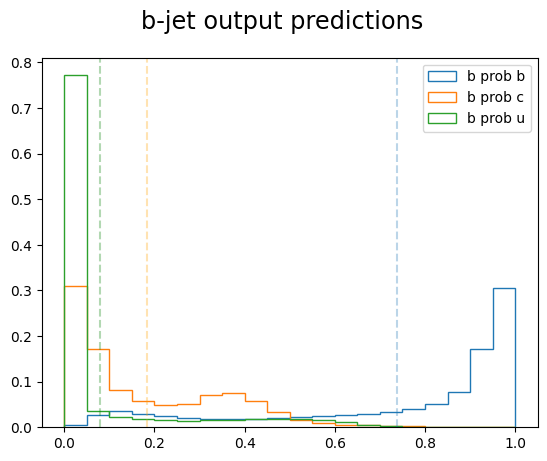

In [70]:
bins=np.linspace(-.000001,1.0001,21)

plt.hist(b_prob_bs, weights=[1/len(b_prob_bs) for _ in range(len(b_prob_bs))], histtype='step', bins=bins, label="b prob b")
plt.hist(b_prob_cs, weights=[1/len(b_prob_cs) for _ in range(len(b_prob_cs))], histtype='step', bins=bins, label="b prob c")
plt.hist(b_prob_us, weights=[1/len(b_prob_us) for _ in range(len(b_prob_us))], histtype='step', bins=bins, label="b prob u")

plt.axvline(np.mean(b_prob_bs), linestyle="--", alpha=0.3)
plt.axvline(np.mean(b_prob_cs), linestyle="--", color="orange", alpha=0.3)
plt.axvline(np.mean(b_prob_us), linestyle="--", color="green", alpha=0.3)


plt.suptitle("b-jet output predictions", fontsize="xx-large")

plt.legend()

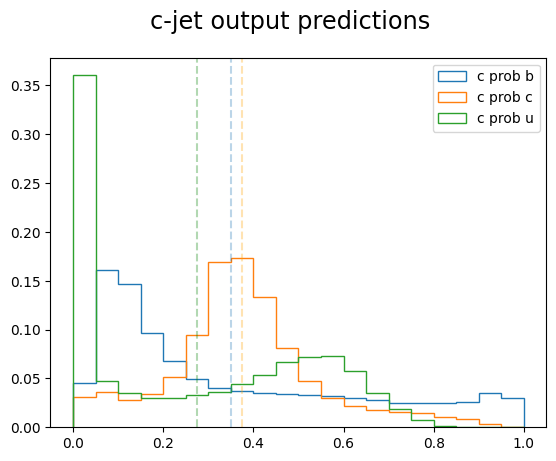

In [69]:
bins=np.linspace(-.000001,1.0001,21)

plt.hist(c_prob_bs, weights=[1/len(c_prob_bs) for _ in range(len(c_prob_bs))], histtype='step', bins=bins, label="c prob b")
plt.hist(c_prob_cs, weights=[1/len(c_prob_cs) for _ in range(len(c_prob_cs))], histtype='step', bins=bins, label="c prob c")
plt.hist(c_prob_us, weights=[1/len(c_prob_us) for _ in range(len(c_prob_us))], histtype='step', bins=bins, label="c prob u")

plt.axvline(np.mean(c_prob_bs), linestyle="--", alpha=0.3)
plt.axvline(np.mean(c_prob_cs), linestyle="--", color="orange", alpha=0.3)
plt.axvline(np.mean(c_prob_us), linestyle="--", color="green", alpha=0.3)

plt.suptitle("c-jet output predictions", fontsize="xx-large")
plt.legend()


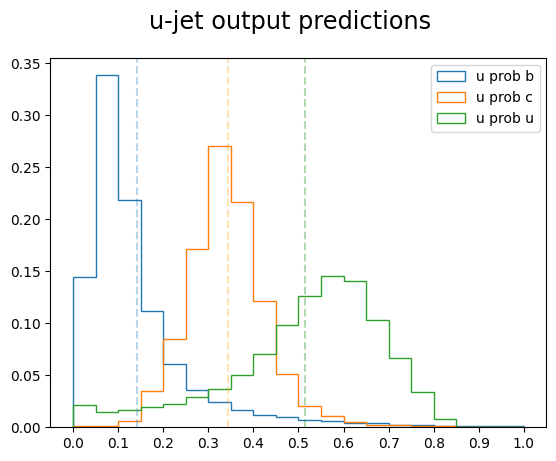

In [68]:
bins=np.linspace(-.000001,1.0001,21)

plt.hist(u_prob_bs, weights=[1/len(u_prob_bs) for _ in range(len(u_prob_bs))], histtype='step', bins=bins, label="u prob b")
plt.hist(u_prob_cs, weights=[1/len(u_prob_cs) for _ in range(len(u_prob_cs))], histtype='step', bins=bins, label="u prob c")
plt.hist(u_prob_us, weights=[1/len(u_prob_us) for _ in range(len(u_prob_us))], histtype='step', bins=bins, label="u prob u")

plt.axvline(np.mean(u_prob_bs), linestyle="--", alpha=0.3)
plt.axvline(np.mean(u_prob_cs), linestyle="--", color="orange", alpha=0.3)
plt.axvline(np.mean(u_prob_us), linestyle="--", color="green", alpha=0.3)

plt.suptitle("u-jet output predictions", fontsize="xx-large")
plt.xticks(np.linspace(0,1,11))
plt.legend()


found previous cached outputs


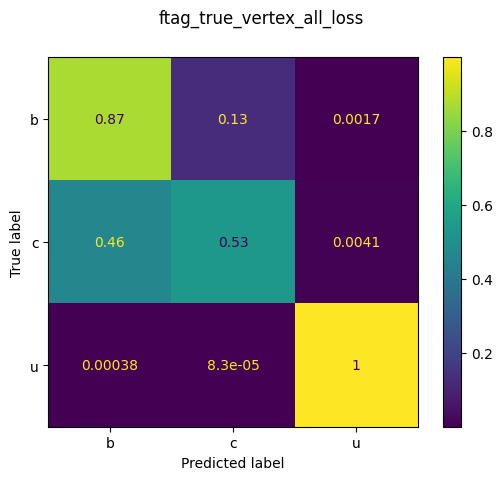

In [2]:
# make confusion matrix of predictions
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def flavor_tag_confusion_matrix(model_config, train_epoch=200):
    """ Create confusion matrix plot for flavor tag on given config"""

    model_outs = ph.get_test_output(model_config, train_epoch)

    # first calculate prediction w/ 0=b, 1=c, 2=u by taking maximum probability from the softmax
    b_preds = np.argmax(model_outs["b_output_arr"][:,daf.JetPrediction.PROB_B:daf.JetPrediction.PROB_U+1], axis=1)
    c_preds = np.argmax(model_outs["c_output_arr"][:,daf.JetPrediction.PROB_B:daf.JetPrediction.PROB_U+1], axis=1)
    u_preds = np.argmax(model_outs["u_output_arr"][:,daf.JetPrediction.PROB_B:daf.JetPrediction.PROB_U+1], axis=1)

    all_preds = np.concatenate((b_preds, c_preds, u_preds))

    b_truth = [0 for _ in range(len(b_preds))]
    c_truth = [1 for _ in range(len(c_preds))]
    u_truth = [2 for _ in range(len(u_preds))]

    all_truth = np.concatenate((b_truth, c_truth, u_truth))

    labels = [0, 1, 2]

    cm = confusion_matrix(all_truth, all_preds, labels=labels, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["b", "c", "u"])
    disp.plot()
    plt.suptitle(model_config)
    plt.show()

flavor_tag_confusion_matrix("ftag_true_vertex_all_loss")

found previous cached outputs


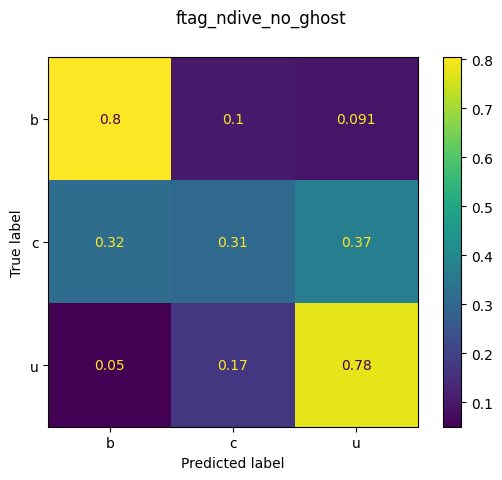

In [42]:
flavor_tag_confusion_matrix("ftag_ndive_no_ghost")

found previous cached outputs


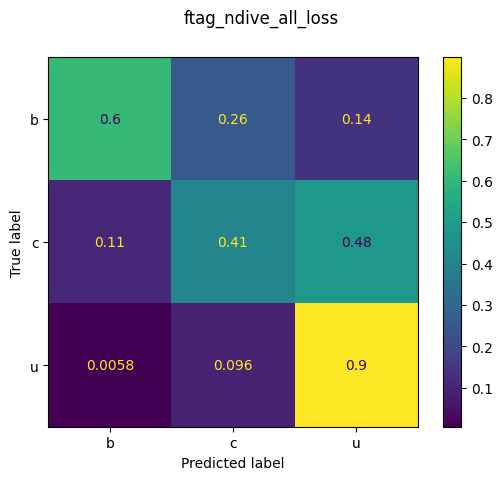

In [5]:
flavor_tag_confusion_matrix("ftag_ndive_all_loss")

found previous cached outputs


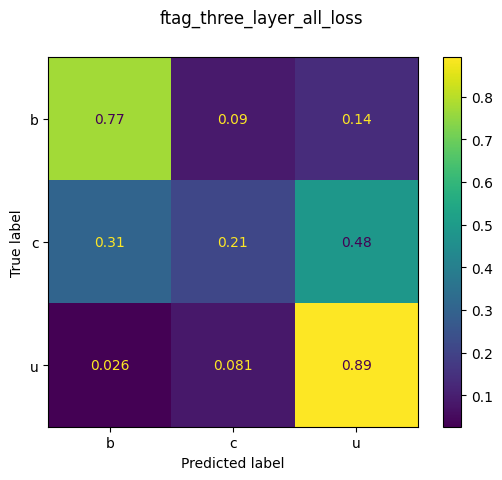

In [90]:
flavor_tag_confusion_matrix("ftag_three_layer_all_loss")

found previous cached outputs


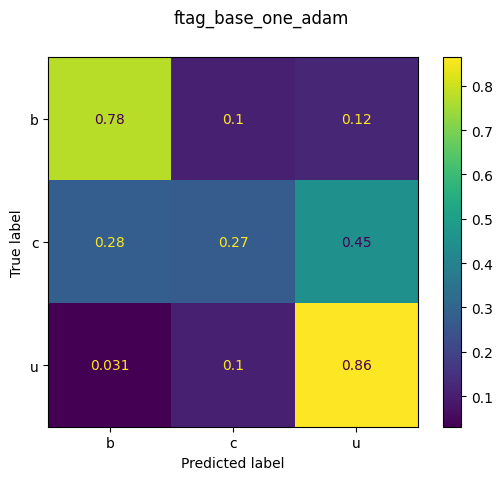

In [4]:
flavor_tag_confusion_matrix("ftag_base_one_adam", train_epoch=220)

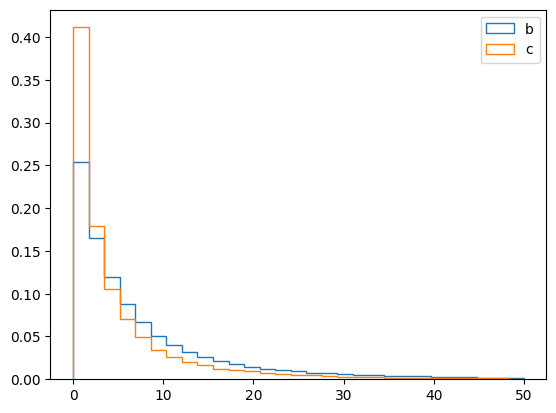

In [51]:
def get_lxy(inputs):
    """ get decay length jet-wise """ 
    return np.sqrt(
        np.square(inputs[:,0,daf.JetData.HADRON_X])
        +np.square(inputs[:,0,daf.JetData.HADRON_Y])
        +np.square(inputs[:,0,daf.JetData.HADRON_Z])
    )


b_decay_lengths = get_lxy(outs["b_input_arr"])
c_decay_lengths = get_lxy(outs["c_input_arr"])

bins = np.linspace(0, 50, 30)
plt.hist(b_decay_lengths, label="b", weights=np.repeat(1/len(b_decay_lengths), len(b_decay_lengths)), bins=bins, histtype='step')
plt.hist(c_decay_lengths, label="c", weights=np.repeat(1/len(c_decay_lengths), len(c_decay_lengths)), bins=bins, histtype='step')
plt.legend()